# HIV Treatment

        The objective here is to find an optimal chemotherapy strategy in the treatment of the human immunodeficiency virus (HIV). This problem studies the immune system of an individual. 
        It's been studied for years and it has increased in the recent years, studying the effects of chemotherapy of reducing viral production. AZT is an example witch affects the infectivity of the virus. It's assumed the treatment works for a finite time, until drug resistance occurs. The measure of benefit is based on the increase of CD4+ cells. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Model (Butler, Kirschner and Lenhar) 

Let $T(t)$ and $T_i(t)$ the concentration per unit of volume of free virus particles. Let $\frac{s}{1 + V(t)}$ be the source term from the thymus (generation of new CD4+ cells). Let $r$ be the growth rate of T cells per day. Assumed to be logistic, with maximum level of $T_{max}$. Let $kV(t)T(t)$ be the rate that vitrus infect T cells. Let $m_1, m_2, m_3$ be the natural death rates of uninfected CD4+ T cell, infected and free virus, respectively. $N$ virus particles are produced before the host cell dies. 

The control $u(t)$ is the strength of the chemotherapy, where $u(t) = 0$ is maximum therapy. 

Our objective is to maximize the CD4+ T cell, while minimizing the cost of the control. 

## The problem is as follows

$$ max_u \int_0^{t_{final}} AT(t) - (1 - u(t))^2 dt $$ 

$$ s.a ~~ T'(t) = \frac{s}{1 + V(t)} - m_1T(t) + rT(t)[1 - \frac{T(t) + T_i(t)}{T_{max}}] - u(t)kV(t)T(t) $$

$$ T_i'(t) = u(t)kV(t)T(t) - m_2T_i(t)$$

$$V'(t) = Nm_2T_i(t) - m_3V(t)$$

$$T(0) = T_0 > 0, T_i(0) = T_{i0} > 0, V(0) = V_0 > 0$$

$$0\leq u(t) \leq 1$$

## Functions

Sejam $\lambda_1(t),\lambda_2(t),\lambda_3(t)$ funções deriváveis por partes
   
$\frac{\partial H}{\partial T} = A + \lambda_1(t)[-m_1 + r(1 - \frac{T(t) - T_i(t)}{T_{max}}) - \frac{rT(t)}{T_{max}} - u(t)kV(t)] + \lambda_2(t)u(t)kV(t) = -\lambda_1'(t)$

$\frac{\partial H}{\partial T_i} = - \lambda_1(t)\frac{rT(t)}{T_{max}} - \lambda_2(t)m_2 + \lambda_3(t)Nm_2 = -\lambda_2'(t)$

$\frac{\partial H}{\partial V} = - \lambda_1(t)[\frac{s}{(1 + V(t))^2} + u(t)kT(t)] + \lambda_2(t)u(t)kT(t) - \lambda_3(t)m_3 = -\lambda_3'(t) $

------------------------------------------------------

$\frac{\partial H}{\partial u} = 2(1 - u(t)) - \lambda_1(t)kV(t)T(t) + \lambda_2(t)kV(t)T(t)$

-----------------------------------------------------

$\frac{\partial H}{\partial u} < 0 \Rightarrow u(t) = 0 \Rightarrow 2(1 - u(t)) - \lambda_1(t)kV(t)T(t) + \lambda_2(t)kV(t)T(t) < 0 \Rightarrow 2 < kV(t)T(t)[\lambda_1(t) - \lambda_2(t)] \\ \Rightarrow 
0 > \frac{1}{2}[kV(t)T(t)(\lambda_2(t) - \lambda_1(t)) + 2]$

$\frac{\partial H}{\partial u} > 0 \Rightarrow u(t) = 1 \Rightarrow 2(1 - u(t)) - \lambda_1(t)kV(t)T(t) + \lambda_2(t)kV(t)T(t) > 0 \Rightarrow 0 > kV(t)T(t)[\lambda_1(t) - \lambda_2(t)] \\ \Rightarrow 
1 < \frac{1}{2}[kV(t)T(t)(\lambda_2(t) - \lambda_1(t)) + 2]$

$\frac{\partial H}{\partial u} = 0 \Rightarrow 0 \leq u(t) \leq 1 \Rightarrow 2(1 - u(t)) - \lambda_1(t)kV(t)T(t) + \lambda_2(t)kV(t)T(t) = 0 \Rightarrow u(t) = \frac{1}{2}[kV(t)T(t)(\lambda_2(t) - \lambda_1(t)) + 2]$

Portanto $u^*(t) = \max(0, \min(\frac{1}{2}[kV(t)T(t)(\lambda_2(t) - \lambda_1(t)) + 2],1)) $

In [40]:
class HIVTreatment:
    
    def __init__(self,k,r,s,m1,m2,m3,A,N,Tf,Tmax,T0,I0,V0):
        
        self.k = k
        self.r = r
        self.s = s
        self.m1 = m1
        self.m2 = m2
        self.m3 = m3
        self.A = A
        self.N = N
        self.Tf = Tf
        self.Tmax = Tmax
        self.T0 = T0
        self.I0 = I0
        self.V0 = V0
        
        self.Fg = {"T": lambda T,I,V,u: self.s/(1 + V) - self.m1*T + self.r*T*(1 - (T + I)/self.Tmax)
                                        - self.k*u*V*T,
                  "I": lambda T,I,V,u: u*self.k*V*T - self.m2*I,
                   
                  "V": lambda T,I,V,u: self.N*self.m2*I - self.m3*V
                  }
        
        self.dadj = {"A1": lambda T,I,V,u,lam,adj,i: -self.A - lam*(-self.m1 + self.r*(1 - (T - I)/self.Tmax)
                                                  - self.r*T/Tmax - u*self.k*V) - adj[1][i]*u*self.k*V,
                     "A2": lambda T,I,V,u,lam,adj,i: adj[0][i]*self.s*T/self.Tmax + lam*self.m2 - 
                                                  adj[2][i]*self.N*self.m2,
                     "A3": lambda T,I,V,u,lam,adj,i: adj[0][i]*(self.s/(1 + V)**2 + u*self.k*T) - 
                                                  adj[1][i]*u*T*self.k + lam*self.m3
                    }
        
    Fu = lambda self,T,I,V,u,adj,i: max(0,min(1/2*(self.k*V*T*(adj[1][i] - adj[0][i]) + 2),1))
    
    def runge_kutta_state(self,T,I,V,u,adj,N,h):
        
        for i in range(N):
                
            k11 = self.Fg['T'](T[i],I[i],V[i],u[i])
            k12 = self.Fg['I'](T[i],I[i],V[i],u[i])
            k13 = self.Fg['V'](T[i],I[i],V[i],u[i])

            k21 = self.Fg["T"](T[i]+h*k11/2,I[i],V[i],u[i])
            k22 = self.Fg["I"](T[i],I[i]+h*k12/2,V[i],u[i])
            k23 = self.Fg["V"](T[i],I[i],V[i]+h*k13/2,u[i])

            k31 = self.Fg["T"](T[i]+h*k21/2,I[i],V[i],u[i])
            k32 = self.Fg["I"](T[i],I[i]+h*k22/2,V[i],u[i])
            k33 = self.Fg["V"](T[i],I[i],V[i]+h*k23/2,u[i])

            k41 = self.Fg["T"](T[i]+h*k31,I[i],V[i],u[i])
            k42 = self.Fg["I"](T[i],I[i]+h*k32,V[i],u[i])
            k43 = self.Fg["V"](T[i],I[i],V[i]+h*k33,u[i])

            T[i+1] = T[i] + (h/6)*(k11 + 2*k21 + 2*k31 + k41)
            I[i+1] = I[i] + (h/6)*(k12 + 2*k22 + 2*k32 + k42)
            V[i+1] = V[i] + (h/6)*(k13 + 2*k23 + 2*k33 + k43)

        return T,I,V

    def runge_kutta_adj(self,T,I,V,u,adj,N,h):
    
        for i in range(N,0,-1):
            
            k11 = self.dadj["A1"](T[i],I[i],V[i],u[i],adj[0][i],adj,i)
            k12 = self.dadj["A2"](T[i],I[i],V[i],u[i],adj[1][i],adj,i)
            k13 = self.dadj["A3"](T[i],I[i],V[i],u[i],adj[2][i],adj,i)

            k21 = self.dadj["A1"](T[i],I[i],V[i],u[i],adj[0][i]+h*k11/2,adj,i)
            k22 = self.dadj["A2"](T[i],I[i],V[i],u[i],adj[1][i]+h*k12/2,adj,i)
            k23 = self.dadj["A3"](T[i],I[i],V[i],u[i],adj[2][i]+h*k13/2,adj,i)

            k31 = self.dadj["A1"](T[i],I[i],V[i],u[i],adj[0][i]+h*k21/2,adj,i)
            k32 = self.dadj["A2"](T[i],I[i],V[i],u[i],adj[1][i]+h*k22/2,adj,i)
            k33 = self.dadj["A3"](T[i],I[i],V[i],u[i],adj[2][i]+h*k23/2,adj,i)

            k41 = self.dadj["A1"](T[i],I[i],V[i],u[i],adj[0][i]+h*k31,adj,i)
            k42 = self.dadj["A2"](T[i],I[i],V[i],u[i],adj[1][i]+h*k32,adj,i)
            k43 = self.dadj["A3"](T[i],I[i],V[i],u[i],adj[2][i]+h*k33,adj,i)
            
            adj[0][i-1] = adj[0][i] - (h/6)*(k11 + 2*k21 + 2*k31 + k41)
            adj[1][i-1] = adj[1][i] - (h/6)*(k12 + 2*k22 + 2*k32 + k42)
            adj[2][i-1] = adj[2][i] - (h/6)*(k13 + 2*k23 + 2*k33 + k43)
        
        return adj
    
    def solve(self):
        #parameters
        N = 100*self.Tf
        h = 1/100
        p = 0.001
        test = -1
        
        #variables
        T = np.zeros(N + 1)
        I = np.zeros(N + 1)
        V = np.zeros(N + 1)
        
        adj = [np.zeros(N + 1) for i in range(3)]
        
        u = np.zeros(N + 1)
        
        T[0],I[0],V[0] = self.T0,self.I0,self.V0
        
        adj[0][-1],adj[1][-1],adj[2][-1] = 0,0,0

        while test < 0:
        
            old_u = u.copy()
            
            old_T = T.copy()
            old_I = I.copy()
            old_V = V.copy()

            old_adj = adj.copy()
            
            T,I,V = self.runge_kutta_state(old_T,old_I,old_V,u,old_adj,N,h)

            adj = self.runge_kutta_adj(T,I,V,u,old_adj,N,h)
            
            for i in range(len(u)): 
                u[i] = 0.5*(self.Fu(T[i],I[i],V[i],u[i],adj,i) + old_u[i])

            temp1 = p*sum(abs(u)) - sum(abs(old_u - u))
            
            temp2 = p*sum(abs(T)) - sum(abs(old_T - T))
            temp3 = p*sum(abs(I)) - sum(abs(old_I - I))
            temp4 = p*sum(abs(V)) - sum(abs(old_V - V))
        
            temp5 = p*sum(abs(adj[0])) - sum(abs(old_adj[0] - adj[0]))
            temp6 = p*sum(abs(adj[1])) - sum(abs(old_adj[1] - adj[1]))
            temp7 = p*sum(abs(adj[2])) - sum(abs(old_adj[2] - adj[2]))
            
            test = min(temp1,temp2,temp3,temp4,temp5,temp6,temp7)
        
        return T,I,V,u
    
    def print(self):
        
        T,I,V,u = self.solve()
        
        t = np.linspace(0,self.Tf,100*self.Tf + 1)

        fig = plt.figure(figsize=(12,24))
        plt.subplot(4,1,1)
        plt.plot(t, T)
        plt.title('CD4+ Cells')
        plt.subplot(4,1,2)
        plt.plot(t, I)
        plt.title('CD4+ Infected Cells')
        plt.subplot(4,1,3)
        plt.plot(t, V)
        plt.title('Free Virus')
        plt.subplot(4,1,4)
        plt.plot(t, u)
        plt.title('Control')
        plt.show()

## Testing with some parameters

In [41]:
k,r,s,m1,m2,m3,A,N,Tf,Tmax,T0,I0,V0 = 0.000024,0.03,10,0.02,0.5,4.4,0.05,300,20,1500,800,0.04,1.5

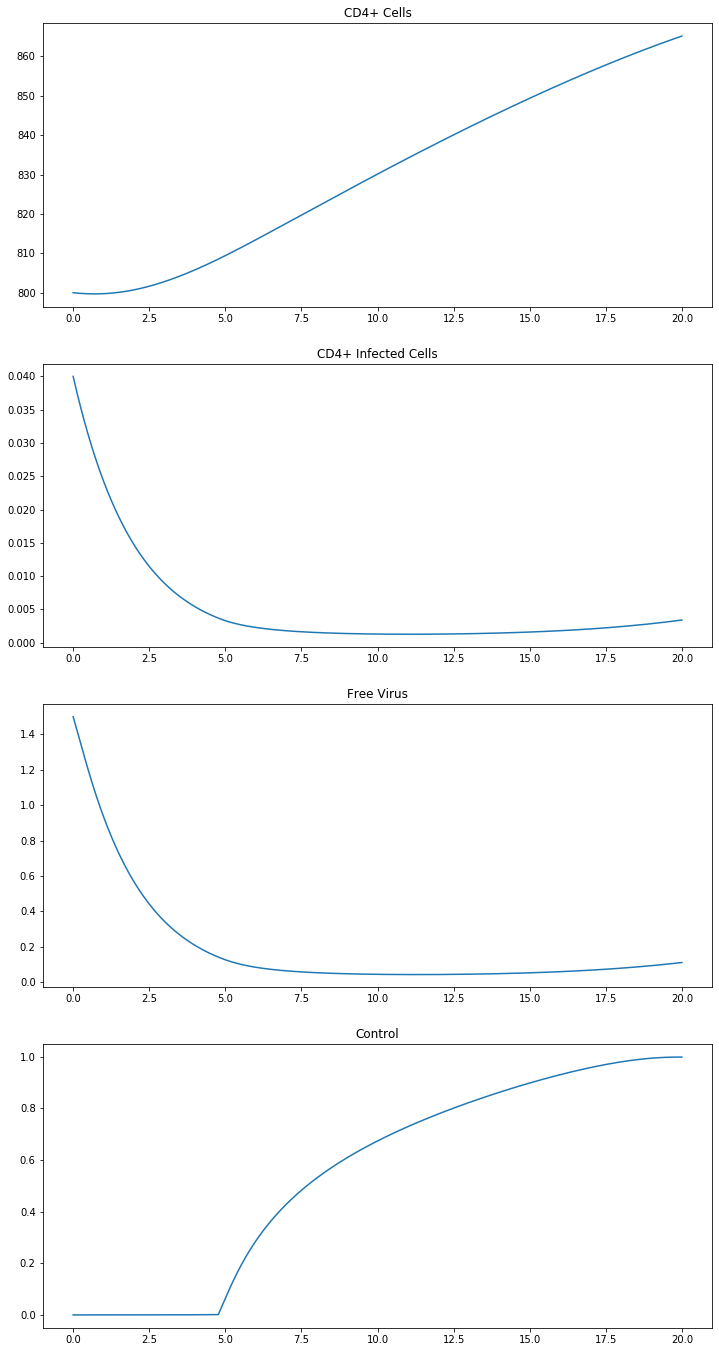

In [43]:
problem = HIVTreatment(k,r,s,m1,m2,m3,A,N,Tf,Tmax,T0,I0,V0)

problem.print()

    Agora, vejamos quando variamos o parâmetro A
    
A = 0.025
problem = HIVTreatment(k,r,s,m1,m2,m3,A,N,Tf,Tmax,T0,I0,V0)

problem.print()